In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline

## Очистка
Импортируем датасет и приведём его в удобных для анализа вид

In [169]:
subscriptions_info = pd.read_csv('subscriptions_info_2023-05-13.csv', index_col=0)

In [170]:
subscriptions_info

,user_id,subscription_id,name,tag
0,3326,50773809,Лига Твоих Путешествий,"Туризм, путешествия"
1,3326,57302136,Байки лаовая. Китай,Дискуссионный клуб
2,3326,122559372,Как в лучших домах Парижу,Дизайн интерьера
3,3326,60394841,Неизвестная Россия,"Туризм, путешествия"
4,3326,39695140,Типичный Милитарист,Вымышленный персонаж
...,...,...,...,...
11,775209069,28244389,Приморский район,Городское сообщество
12,775209069,159478970,МИР КУЛИНАРИИ,"Кулинария, рецепты"
13,775209069,217992260,Доктор Бабовников. Травматолог- ортопед,Врач
14,775209069,217992260,Доктор Бабовников. Травматолог- ортопед,Врач


Видим, что встречаются дубликаты. Нужно их удалить

In [171]:
subscriptions_info.drop_duplicates(inplace=True)

In [172]:
subscriptions_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745709 entries, 0 to 13
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   user_id          745709 non-null  int64 
 1   subscription_id  745709 non-null  int64 
 2   name             745704 non-null  object
 3   tag              745709 non-null  object
dtypes: int64(2), object(2)
memory usage: 28.4+ MB


Посмотрим на тэги

In [5]:
subscriptions_info.tag.value_counts()

Городское сообщество                                                                                                                                                                       44466
Творчество                                                                                                                                                                                 34696
Образование                                                                                                                                                                                32962
Юмор                                                                                                                                                                                       30585
Литература                                                                                                                                                                                 22102
                                   

У нас есть тэги, которые присваиваются заблокированным сообществам. Нужно от них избавиться

In [6]:
filtered_subscriptions = subscriptions_info[~subscriptions_info['tag'].str.contains('Этот материал заблокирован')]

In [7]:
filtered_subscriptions.tag.value_counts()

Городское сообщество    44466
Творчество              34696
Образование             32962
Юмор                    30585
Литература              22102
                        ...  
Биатлонист                  1
Парк                        1
Боксер                      1
Почтовая служба             1
Волейболист                 1
Name: tag, Length: 458, dtype: int64

## Данные
Теперь посмотрим на сами данные

#### Количество уникальных подписчиков

In [8]:
filtered_subscriptions.user_id.nunique()

6335

#### Описательные статистики по количеству подпискок
Для каждого пользователя было выбрано 200 подписок, которые наиболее отражают его интересы

In [9]:
filtered_subscriptions.groupby('user_id') \
                    .agg({'name':'count'}) \
                    .name.describe()

count    6335.000000
mean      117.412944
std        71.211357
min         1.000000
25%        50.000000
50%       115.000000
75%       198.000000
max       200.000000
Name: name, dtype: float64

#### Количество уникальных групп

In [10]:
filtered_subscriptions.name.nunique()

178810

#### Топ-15 самых популярных групп

In [11]:
filtered_subscriptions.name.value_counts().head(15)

Интересные события в Санкт-Петербурге              1338
Книги                                              1067
Интересный Питер                                   1051
Правительство Санкт-Петербурга                     1012
KudaGo: Санкт-Петербург                             861
Горбилет – билеты со скидкой                        813
Это Питер, детка! [Типичный Питер]                  808
Ищу модель Питер                                    780
Приморский Онлайн | Новости нашего района | СПб     775
Vandrouki | Путешествия почти бесплатно (RU)        750
Мой Питер                                           675
Афиша событий Петербурга                            660
ДЕТСКИЕ ПОДЕЛКИ                                     629
Бесплатный Питер                                    627
Библиотека имени Маяковского                        615
Name: name, dtype: int64

На графике

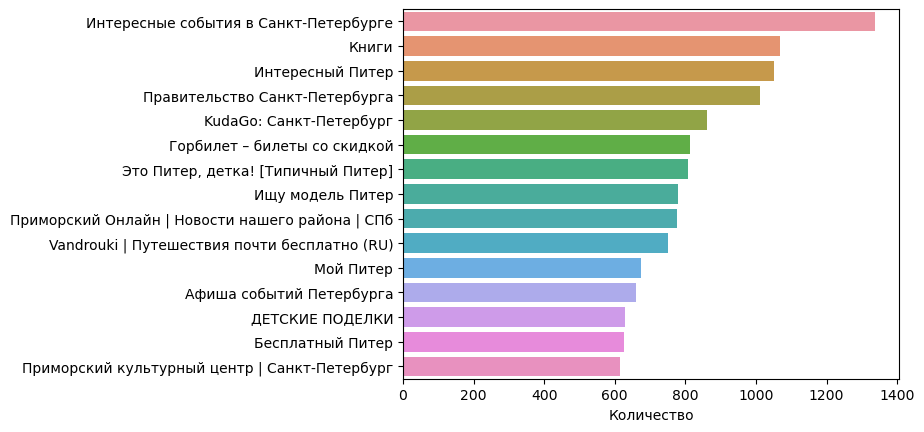

In [180]:
top15_groups = filtered_subscriptions.groupby('name', as_index=False) \
                    .agg({'subscription_id': 'count'}) \
                    .sort_values('subscription_id', ascending=False) \
                    .head(15)

ax = sns.barplot(data=top15_groups,
                 y='name',
                 x='subscription_id')

ax.set_ylabel('')
ax.set_xlabel('Количество')
plt.show()

#### Количество уникальных тэгов

In [12]:
filtered_subscriptions.tag.nunique()

458

#### Описательные статистики для уникальных тэгов в группах подписчиков

In [13]:
filtered_subscriptions.groupby('user_id') \
    .agg({'tag': 'nunique'}) \
    .tag.describe()

count    6335.000000
mean       47.071507
std        24.217950
min         1.000000
25%        27.000000
50%        48.000000
75%        65.000000
max       111.000000
Name: tag, dtype: float64

#### Топ-15 самых популярных тэгов

In [14]:
filtered_subscriptions.tag.value_counts().head(15)

Городское сообщество           44466
Творчество                     34696
Образование                    32962
Юмор                           30585
Литература                     22102
Культура                       21195
Интернет-СМИ                   18416
Библиотека                     15693
Государственная организация    15576
Родители и дети                15075
Кулинария, рецепты             14662
Туризм, путешествия            14467
Кино                           11755
Здоровый образ жизни           11569
Объявления                     10919
Name: tag, dtype: int64

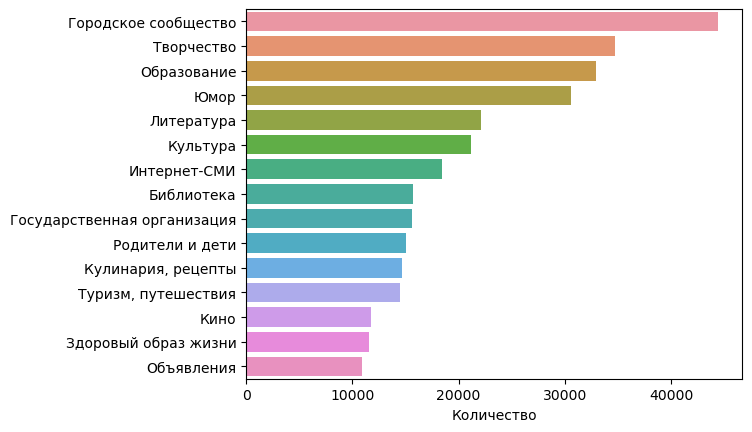

In [182]:
top15_tags = filtered_subscriptions.groupby('tag', as_index=False) \
                    .agg({'subscription_id': 'count'}) \
                    .sort_values('subscription_id', ascending=False) \
                    .head(15)

ax = sns.barplot(data=top15_tags,
                 y='tag',
                 x='subscription_id')

ax.set_ylabel('')
ax.set_xlabel('Количество')
plt.show()

## Тэги
В датасете присутсвуют тэги, которые можно объединить в более общие группы. Была составлена таблица общих тэгов.

In [15]:
tags = pd.read_excel('tags.xlsx', sheet_name="try2")

In [16]:
tags.head()

,activism,ads,job,meeting,adverts,animals,art,auto,adult,blog,...,recreation,religion,science,service,shopping,site,sport,technology,travel,videogames
0,Общественный деятель,Реклама,Поиск работы,Знакомства,Объявления,Зоомагазин,Художник,Услуги для автовладельцев,Эротика,Блог,...,"Санаторий, дом отдыха",Духовное лицо,Философия,Другие услуги,Потребительские товары,Вконтакте,Спортивный клуб,Высокие технологии,Туристическое агентство,Игра
1,Благотворительность,NaN,NaN,NaN,NaN,Зоопарк,Художница,Автовладельцы,Товары для взрослых,Производство контента,...,Парк отдыха,Религиозное учреждение,История,Профессиональные услуги,Товар,Сайт,Другие виды спорта,Программное обеспечение,"Туры, экскурсии",Видеоигры
2,Благотворительная организация,NaN,NaN,NaN,NaN,Домашние и дикие животные,Художник или художница,Аренда автомобилей,NaN,Блогер,...,Активный отдых,Религия,Наука,Интернет-провайдер,Другие товары,Сайты,Спортивная организация,Программирование,"Туризм, путешествия",Игры
3,Общественная организация,NaN,NaN,NaN,NaN,Товары для животных,Творческое объединение,Автосервис,NaN,Критик,...,Организация праздников,Языки,Юриспруденция,Транспортные услуги,Товары для праздников,ВКонтакте,Спортивная команда,Электроника,"Аэропорт, вокзал",Видеоигра
4,Молодёжное движение,NaN,NaN,NaN,NaN,Услуги для владельцев животных,NaN,Автомобили,NaN,NaN,...,NaN,"Астрология, эзотерика",NaN,Пассажирские перевозки,Товары для дома,NaN,Футбол,Интернет,"Продажа билетов, бронирование гостиниц",Стример


In [17]:
# Функция для перевода датафрейма в словарь вида {'колонка': 'значения'}
def dataframe_to_dict(df):
    result_dict = {}
    columns = df.columns.tolist()  # Получаем список названий колонок

    for column in columns:
        result_dict[column] = df[column].dropna().tolist()  # Исключаем NaN значения из списка

    return result_dict

In [18]:
tags_dict = dataframe_to_dict(tags)

In [19]:
#Проверим
tags_dict['activism']

['Общественный деятель',
 'Благотворительность',
 'Благотворительная организация',
 'Общественная организация',
 'Молодёжное движение',
 'Некоммерческая организация',
 'Общественное движение']

Добавим в датасет общие тэги

In [20]:
df = filtered_subscriptions.copy()

In [21]:
# Функиця для присвоения новых тэгов
def find_key(value):
    global tags_dict
    for key, values in tags_dict.items():
        if value in values:
            return key
    return f"значения {value} нет в списке"

In [22]:
df['general_tag']= df.tag.apply(find_key)

In [23]:
df.head()

,user_id,subscription_id,name,tag,general_tag
0,3326,50773809,Лига Твоих Путешествий,"Туризм, путешествия",travel
1,3326,57302136,Байки лаовая. Китай,Дискуссионный клуб,hobby
2,3326,122559372,Как в лучших домах Парижу,Дизайн интерьера,design
3,3326,60394841,Неизвестная Россия,"Туризм, путешествия",travel
4,3326,39695140,Типичный Милитарист,Вымышленный персонаж,fan


Проверим, добавились ли все тэги

In [24]:
df.general_tag.nunique()

66

#### Описательные статистики для уникальных общих тэгов в группах подписчиков

In [25]:
df.groupby('user_id') \
    .agg({'general_tag': 'nunique'}) \
    .general_tag.describe()

count    6335.000000
mean       29.567640
std        11.828975
min         1.000000
25%        21.000000
50%        32.000000
75%        39.000000
max        55.000000
Name: general_tag, dtype: float64

#### Посмотрим на топ-15 общих тэгов

In [26]:
df.general_tag.value_counts().head(15)

literature    52368
city          44466
creativity    36883
education     32962
humor         30855
music         26676
cinema_tv     24314
culture       22764
media         21025
travel        20954
children      19625
fashion       18323
perfomance    18113
health        17521
science       17454
Name: general_tag, dtype: int64

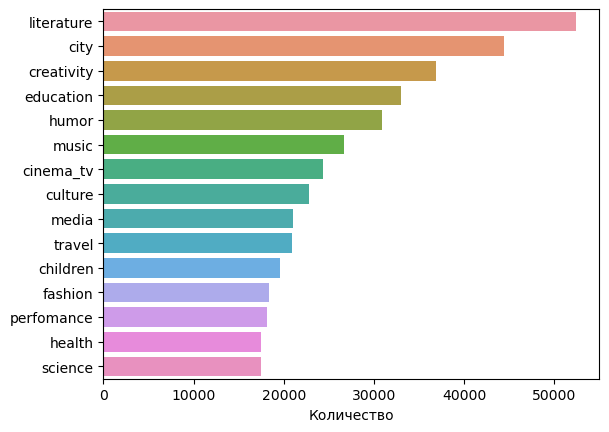

In [183]:
top15_groups = df.groupby('general_tag', as_index=False) \
                    .agg({'subscription_id': 'count'}) \
                    .sort_values('subscription_id', ascending=False) \
                    .head(15)

ax = sns.barplot(data=top15_groups,
                 y='general_tag',
                 x='subscription_id')

ax.set_ylabel('')
ax.set_xlabel('Количество')
plt.show()

## Подготовка к кластеризации
Посмотрим новую таблицу, в которой для каждого пользователя будет посчитатано количество тэгов сообществ, на которые он подписан

In [253]:
df_pivot = df.pivot_table(values='name', index='user_id', columns='general_tag', aggfunc='count', fill_value=0) \
            .rename_axis(None, axis=1)

In [254]:
df_pivot.head()

,activism,ads,adult,adverts,animals,art,auto,beauty,blog,business,...,service,shopping,site,society,sport,teacher,technology,travel,university,videogames
user_id,,,,,,,,,,,,,,,,,,,,,
821,5,0,0,2,0,1,0,0,1,2,...,5,3,1,0,6,0,0,3,0,0
1292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0
3172,0,7,0,1,2,0,3,1,4,12,...,2,2,7,2,4,0,2,5,0,0
3326,2,0,0,0,2,4,5,0,1,3,...,1,0,2,5,1,0,9,23,3,0
3357,0,1,0,1,2,1,0,1,2,1,...,2,1,1,0,4,0,0,9,0,0


## Кластеризация
Воспользуемся методом k-средний (k-means), чтобы на основе тэгов разделить пописчиков групп библиотек на кластеры с общими интересами

#### Стандартизация
Приведем все данные к Z-значениям по формуле.

$$
Z = \frac{X - \text u}{\text sd}
$$

Где:
+ Х - значение
+ u - среднее значение
+ sd - стандартное отклонение

Это делается для того, чтобы избежать искажения результатов выборки из-за выбросов, а также учесть влияние всех переменных. 

In [29]:
# Стандартизация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pivot)

#### Определение оптимального числа кластеров
Воспользуемся методом локтя, чтобы определить нужное нам число кластеров

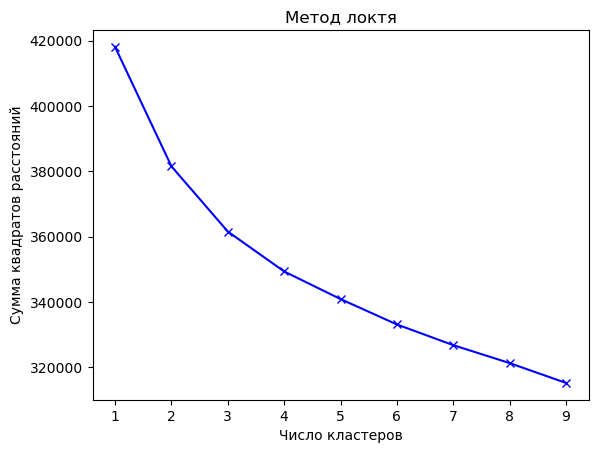

In [30]:
# Вычисление суммы квадратов расстояний для разного числа кластеров
sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_data)
    sum_of_squared_distances.append(kmeans.inertia_)

# Визуализация метода локтя
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя')
plt.show()

На графике не наблюдаем очень явный излом. Небольшие перемены есть на значениях 2 и 3, однако заказчик просил как можно подробнее описать аудиторию, поэтому возьмём побольше кластеров. Методом подбора было выбрано число 6.

#### Применение алгоритма k-средних

In [31]:
k = 6 # Число кластеров
kmeans = KMeans(n_clusters=k, max_iter=300)
kmeans.fit(scaled_data)


KMeans(n_clusters=6)

In [265]:
# Получение меток кластеров
labels = kmeans.labels_

# Добавление меток кластеров в исходный датафрейм
df_pivot['cluster'] = labels

In [276]:
# Изменим номера кластеров на буквы, чтобы легче читалось
df_pivot['cluster'] = df_pivot.cluster.apply(lambda x: [i for i in 'ABCDEF'][x])

## Результаты

#### Для начала выведем топ-15 самых популярных тэгов для каждого кластера

In [317]:
cluster_data = df_pivot.groupby('cluster', as_index=False).mean()

# Получение списка столбцов с тегами
tag_columns = cluster_data.iloc[:, 1:].columns

# Топ-15 тегов для каждого кластера
for cluster in cluster_data['cluster'].unique():
    print(f"Cluster {cluster}:")
    cluster_tags = cluster_data.loc[cluster_data['cluster'] == cluster, tag_columns]
    top_tags = cluster_tags.melt().nlargest(15, 'value').reset_index(drop=True)
    print(top_tags.to_string(index=False, header=False))
    print()

Cluster A:
     humor 19.714545
creativity 11.876364
     music 10.905455
 cinema_tv 10.700000
literature 10.500000
     photo  8.960000
 education  7.152727
   science  5.996364
      city  5.929091
   culture  5.718182
   fashion  5.530909
   animals  4.847273
       art  4.069091
     media  3.981818
perfomance  3.649091

Cluster B:
literature 4.175099
      city 3.293035
creativity 2.505585
 education 2.444152
     humor 1.845598
   culture 1.694152
    travel 1.667871
 cinema_tv 1.615966
     music 1.511827
  children 1.504928
     media 1.356767
perfomance 1.325887
government 1.309461
   courses 1.285151
    health 1.249671

Cluster C:
     adverts 16.138614
        city 15.953795
       music 15.755776
        auto  9.900990
  videogames  7.260726
         job  7.029703
       humor  6.726073
     service  6.372937
      beauty  5.834983
     fashion  4.693069
  technology  4.580858
construction  4.343234
       sport  4.254125
       media  4.227723
   cinema_tv  4.191419

Clus

####  Построим свобдную таблицу с информацией по каждому кластеру

In [318]:
# Сначала построим таблицу с количеством пользователей в каждом кластере и их долей от общего числа
clstr = pd.concat([df_pivot.cluster.value_counts(),
                     df_pivot.cluster.value_counts(normalize=True).apply(lambda x: x * 100)],
                    axis=1,
                    keys=('count_users', 'percent'))


clstr = clstr.reset_index().rename(columns={'index':'cluster'})

In [319]:
# Теперь посчитаем количество подписок у каждого пользователя
group_count = df.groupby('user_id', as_index=False) \
    .agg({'subscription_id': 'count'}) \
    .rename(columns={'subscription_id':'group_count'})

clustered_users = df_pivot.reset_index()

# И объединим их с таблицей с кластерами
merged_users = clustered_users.merge(group_count, on='user_id', how='inner')

# Посчитаем среднее количество подписок у пользователя в каждом кластере
gr_cnt = merged_users.groupby('cluster', as_index=False) \
            .agg({'group_count': 'mean'})

In [344]:
# Выведем всё вместе

data = clstr.merge(gr_cnt, on='cluster', how='inner')

data

,cluster,count_users,percent,group_count
0,B,3044,48.050513,50.918857
1,D,1295,20.441989,172.358301
2,E,1020,16.101026,181.662745
3,A,550,8.681926,180.774545
4,C,303,4.782952,191.234323
5,F,123,1.941594,186.577236


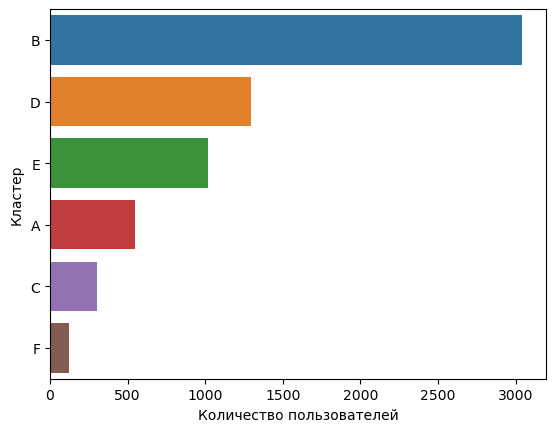

In [345]:
data['cluster'] = data['cluster'].apply(str)
for_plot = data[['cluster', 'count_users']]

ax = sns.barplot(data=for_plot,
                 x='count_users',
                 y='cluster')
ax.set_xlabel('Количество пользователей')
ax.set_ylabel('Кластер')
plt.show()

#### Пол и возраст в кластерах

Импортируем датасет с демографическими данными

In [346]:
subs_info = pd.read_csv('subscribers_data_final.csv', index_col=0)
subs_info.head()

,id,sex,bdate,city,university,graduation,is_closed,group_name,age
0,1378,female,2.2,Санкт-Петербург,СПбГУ,2010.0,True,Библиотеки Приморского района,NaN
1,2006,female,18.8.1984,Санкт-Петербург,СПбГИК,2006.0,True,Библиотеки Приморского района,39.0
2,3269,male,26.12.1986,Санкт-Петербург,NaN,NaN,True,Библиотеки Приморского района,37.0
3,3326,male,6.5.1986,Санкт-Петербург,СПбГЭТУ,2009.0,False,Библиотеки Приморского района,37.0
4,3357,female,13.8,Санкт-Петербург,NaN,NaN,False,Библиотеки Приморского района,NaN


Отберем нужные колонки

In [347]:
subs_info = subs_info[['id', 'sex', 'age']].rename(columns={'id': 'user_id'}).drop_duplicates()
subs_info.head()

,user_id,sex,age
0,1378,female,NaN
1,2006,female,39.0
2,3269,male,37.0
3,3326,male,37.0
4,3357,female,NaN


Соединим информацию о поле с датасетом с подписками и добавим в таблицу

In [348]:
# Добавляем колонки в датасет
merged_sex_age = merged_users.merge(subs_info, on='user_id', how='inner')

# Считаем количество представителей каждого пола
sex = merged_sex_age.groupby(['cluster', 'sex'], as_index=False) \
            .agg({'user_id': 'count'}) \
            .pivot(index='cluster', columns='sex', values='user_id') \
            .reset_index()

#Добавляем
data = data.merge(sex, on='cluster', how='inner')

data

,cluster,count_users,percent,group_count,female,male
0,B,3044,48.050513,50.918857,2620,422
1,D,1295,20.441989,172.358301,1271,24
2,E,1020,16.101026,181.662745,831,189
3,A,550,8.681926,180.774545,416,134
4,C,303,4.782952,191.234323,113,190
5,F,123,1.941594,186.577236,71,52


In [349]:
#Посчитаем процентное соотношение
data['female'] = round(data.female / data.count_users * 100, 2)
data['male'] = round(data.male / data.count_users * 100, 2)

С возрастом будет сложнее делать какие-то выводы, так как более чем у половины пользователей он не указан

In [350]:
merged_sex_age[['user_id', 'age']].drop_duplicates().age.isna().sum()

3630

Тем не менее, добавим его в таблицу. Резульатат заказчику будем представлять с оговоркой

In [352]:
# Считаем средний возраст
age = merged_sex_age.groupby('cluster', as_index=False) \
                .agg({'age': ['mean', 'count']})
age.columns = ['cluster', 'mean_age', 'count_age']

data = data.merge(age, on='cluster', how='inner')

In [353]:
# Переименуем колонки
new_names = ['Кластер', 
             'Количество пользователей', 
             'Процент', 
             'Среднее количество подписок у пользователей',
             'Процент женщин',
             'Процент мужчин',
             'Средний возраст',
             'Процент указавших возраст']
data.columns = new_names

In [354]:
data['Процент указавших возраст'] = round(data['Процент указавших возраст'] / data['Количество пользователей'] * 100, 2)

In [355]:
data

,Кластер,Количество пользователей,Процент,Среднее количество подписок у пользователей,Процент женщин,Процент мужчин,Средний возраст,Процент указавших возраст
0,B,3044,48.050513,50.918857,86.07,13.86,43.735531,44.84
1,D,1295,20.441989,172.358301,98.15,1.85,43.087640,34.36
2,E,1020,16.101026,181.662745,81.47,18.53,48.407507,36.57
3,A,550,8.681926,180.774545,75.64,24.36,32.443983,43.82
4,C,303,4.782952,191.234323,37.29,62.71,33.115880,76.90
5,F,123,1.941594,186.577236,57.72,42.28,38.895833,39.02


### Выгрузка данных
Выгрузим данные, чтобы визуализировать их в Power BI

In [167]:
df.to_csv('subscriptions_info_final.csv')

In [168]:
df_pivot.to_csv('cluster_data_final.csv')